In [1]:
import tensorflow_probability as tfp
import numpy as np
import tensorflow as tf

import time
from tqdm import tqdm
import pickle


import matplotlib.dates as mdates
import matplotlib.ticker as ticker

myFmt = mdates.DateFormatter('%Hh')

import pandas as pd
np.set_printoptions(suppress=True,precision=6)
import matplotlib.pyplot as plt
import matplotlib

plt.style.use('ggplot') 
plt.style.use('seaborn-paper') 
plt.style.use('seaborn-whitegrid')

import sys

from tensorflow_probability import distributions as tfd
from geopy.distance import geodesic

%matplotlib inline

from move_ns import moveNS



## Load data and display individual time series lengths

In [3]:
# set up lower level GP locations covering 24 hours
Z = np.arange(0,24,0.5).astype(np.float64)[:,None]
np.random.shuffle(Z)


In [4]:
def setup_data(skip_i=1,skip=3):
    
    df = pd.read_csv('data/ovejas.csv')

    df = df[df.id!=34]
    df = df[df['id']%skip_i==0]


#     for i in df['id'].unique():

#         thisW = df[df['id']==i]

#         secs =(pd.to_datetime(thisW['time'])- pd.datetime(2000,1,1)).dt.seconds.astype(float).values
#         days = (pd.to_datetime(thisW['time'])- pd.datetime(2000,1,1)).dt.days.astype(float).values
#         T = (days*24*60+secs/60)/(60*24) #days

#         days = np.max(T)-np.min(T)
#         print(i,days,len(thisW))


    df['ID'] = df['id'].astype('category').cat.rename_categories(range(0, df['id'].nunique())).astype('int')
    ID_in = df['ID'].values 
    
    
    
    Xgps = df[['lat','lon']].values
    minX = np.min(Xgps[:,0])
    minY = np.min(Xgps[:,1])




    secs =(pd.to_datetime(df['time'])- pd.datetime(2018,1,1)).dt.seconds.astype(float).values
    days = (pd.to_datetime(df['time'])- pd.datetime(2018,1,1)).dt.days.astype(float).values
    T = (days*24*60+secs/60)/(60*24) #days
    T = T-np.min(T)

    rescale = 24  # use hours to improve numerical stability
    T = T * rescale


    T=T[::skip,None]
    Xgps=Xgps[::skip]
    ID=ID_in[::skip]



    # use geodesic to get the straight line distance between two points
    Xmetres = [geodesic((xloc,minY), (minX,minY)).meters for xloc in Xgps[:,0]]
    Ymetres = [geodesic((minX,yloc), (minX,minY)).meters for yloc in Xgps[:,1]]


    X = np.array([Xmetres, Ymetres]).T
    

    return X, T, ID


In [5]:
X,T,ID = setup_data(skip_i=8)

/home/staff1/ctorney/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
/home/staff1/ctorney/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


In [6]:
print(X.shape)
print(T.shape)
print(Z.shape)

(16945, 2)
(16945, 1)
(48, 1)


## Convert IDs to sequential index and coordinates to metres

## Create arrays for GP

In [7]:
def sp_shift(x):
    # softplus transform with shift 
    return tf.nn.softplus(x)+1e-4

## Set-up the non-stationary GP

In [8]:


def periodic_kernel(x1,x2):
    # periodic kernel with parameter set to encode
    # daily activity pattern (period=rescale).
    return tfp.math.psd_kernels.ExpSinSquared(x1,x2,np.float64(24.0))

# transform for parameter to ensure positive
transforms=[sp_shift,sp_shift] 

# diffuse priors on parameters
lpriors = [tfd.Normal(loc = np.float64(0.),scale=np.float64(10)),
           tfd.Normal(loc = np.float64(0.),scale=np.float64(10)),
           tfd.Normal(loc = np.float64(0.),scale=np.float64(10))]
           
apriors = [tfd.Normal(loc = np.float64(0),scale=np.float64(10.)),
           tfd.Normal(loc = np.float64(0),scale=np.float64(10.)),
           tfd.Normal(loc = np.float64(0.),scale=np.float64(10.))]


lparams_init = [0.0 for p in lpriors]
aparams_init = [0.0 for p in apriors]

# create the model 
mover = moveNS(T,X,Z, ID, BATCH_SIZE=2800, velocity=True, std_obs_noise=100, mean_obs_noise=10,
                        akernel=periodic_kernel, 
                        aparams_init=aparams_init, 
                        apriors=apriors, 
                        atransforms=transforms,
                        lkernel=periodic_kernel, 
                        lparams_init=lparams_init, 
                        lpriors=lpriors, 
                        ltransforms=transforms)

In [9]:

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-1,beta_2=0.99)
train_steps = 10000
pbar = tqdm(range(train_steps))
loss_history = np.zeros((train_steps))
for i in pbar:
    with tf.GradientTape() as t:
        loss = -mover.log_posterior(*mover.kernel_params)
    loss_history[i] = loss.numpy()
    pbar.set_description("Loss %f" % loss_history[i])

    gradients = t.gradient(loss, mover.kernel_params)
    optimizer.apply_gradients(zip(gradients, mover.kernel_params))



Loss 235007.328125: 100%|██████████| 10000/10000 [1:20:38<00:00,  2.07it/s]


## new code for full sampler 

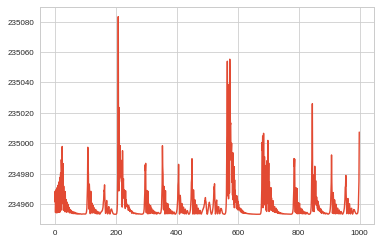

235007.33

In [10]:
plt.plot(loss_history[9000:])
plt.show()
loss.numpy()

In [ ]:
2*100/60

In [ ]:
# opt_step = []
# for var in optimizer.variables():
#     if '/v:' in var.name:
#         opt_step.append((np.sqrt(var.numpy())+1e-0)**-1)
        
        
# plt.plot(opt_step[2][0:48],'.')
# plt.plot(opt_step[6][0:48],'.')
# #plt.ylim(-0.5,1)
# plt.show()

In [11]:
# sample from the posterior
kr = mover.hmc_sample(num_samples=2, skip=0, burn_in=0, num_leapfrog_steps=1, init_step=1e-8)
lengths = mover.get_lengthscale_samples()
amps = mover.get_amplitude_samples()


/home/staff1/ctorney/anaconda3/envs/tf/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/sample.py:336: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


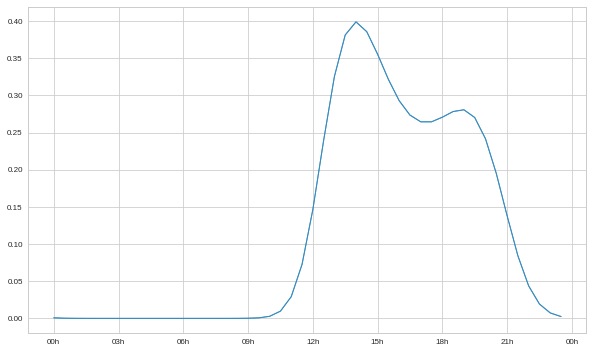

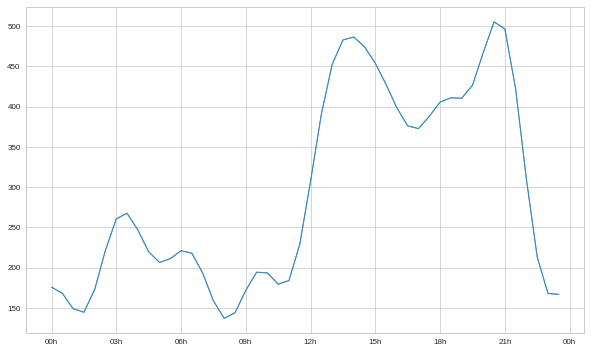

In [12]:
#  plot the sample for checking
plt.figure(figsize=(10,6))
Z_time=np.array([np.datetime64('2019') + np.timedelta64(int(k*60*60), 's') for k in Z])

for i in range(0,lengths.shape[0]):
    plt.plot(Z_time[np.argsort(Z_time)],lengths[i,np.argsort(Z_time)],c='C1',alpha=0.902,linewidth=1.0)

ax = plt.gca()
ax.xaxis_date()
ax.xaxis.set_major_formatter(myFmt)
plt.figure(figsize=(10,6))

for i in range(0,amps.shape[0]):
    plt.plot(Z_time[np.argsort(Z_time)],amps[i,np.argsort(Z_time)],c='C1', alpha=0.902,linewidth=1.0)
ax = plt.gca()
ax.xaxis_date()
ax.xaxis.set_major_formatter(myFmt)


In [13]:

def build_trainable_location_scale_distribution(initial_loc, initial_scale):
    
    with tf.name_scope('build_trainable_location_scale_distribution'):
        dtype = tf.float32
        initial_loc = initial_loc * tf.ones(tf.shape(initial_scale), dtype=dtype)
        
        initial_scale = initial_scale * tf.ones_like(initial_loc)

        loc = tf.Variable(initial_value=initial_loc, name='loc')
      
        
        scale=tfp.util.DeferredTensor(tf.nn.softplus,tf.Variable(initial_scale, name='scale'))

        posterior_dist = tfd.Normal(loc=loc, scale=scale)

        
        posterior_dist = tfd.Independent(posterior_dist)
        
    return posterior_dist


flat_component_dists = []

for kparam in mover.kernel_params:
    init_loc = kparam
    init_scale = tf.random.uniform(shape=kparam.shape, minval=-2, maxval=2, dtype=tf.dtypes.float32)


    flat_component_dists.append(build_trainable_location_scale_distribution(init_loc,init_scale))


surrogate_posterior = tfd.JointDistributionSequential(flat_component_dists)



def target_log_prob_fn(*inputs):
    params = [tf.squeeze(a) for a in inputs]
    loss = mover.log_posterior(*params)
    
    
    return loss




start = time.time()
losses = tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn, surrogate_posterior,
    optimizer=tf.optimizers.Adam(
        learning_rate=0.1,        
        beta_2=0.9),
    num_steps=1500)
end = time.time()
print(end - start)





612.4097883701324


In [18]:
sp = surrogate_posterior.sample(100)
sp_np = [s.numpy() for s in sp]
approximate_posterior_stddevs = [0.1*np.std(x,axis=0) for x in sp]


In [15]:
X,T,ID = setup_data(skip_i=1)


# create the model 
mover_hmc = moveNS(T,X,Z, ID, BATCH_SIZE=2800, velocity=True, std_obs_noise=100, mean_obs_noise=10,
                        akernel=periodic_kernel, 
                        aparams_init=aparams_init, 
                        apriors=apriors, 
                        atransforms=transforms,
                        lkernel=periodic_kernel, 
                        lparams_init=lparams_init, 
                        lpriors=lpriors, 
                        ltransforms=transforms)

/home/staff1/ctorney/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
/home/staff1/ctorney/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


In [16]:
#set values

for pk in range(len(mover.kernel_params)):
    mover_hmc.kernel_params[pk].assign(mover.kernel_params[pk].numpy())


In [19]:

start = time.time()

num_samples=100
burn_in=50
num_runs=1
rescale = 24

for i in range(num_runs):
    

    kr = mover_hmc.hmc_sample(num_samples=num_samples, skip=0, burn_in=burn_in, num_leapfrog_steps=8, init_step=approximate_posterior_stddevs)
   
    # save the results
    final_hmc_np = [j.numpy() for j in  mover_hmc.samples_]
    with open('data/hmc_samples_p_' + str(i) + '.npy', 'wb') as fp:
        pickle.dump(final_hmc_np, fp)
        
    lengths = mover_hmc.get_lengthscale_samples()
    amps = mover_hmc.get_amplitude_samples()
    np.save('data/len_sheep_p_' + str(i) + '.npy',lengths)
    np.save('data/amp_sheep_p_' + str(i) + '.npy',amps)
    
    Z_pred = np.arange(0,1.0*rescale,rescale*0.001).astype(np.float64)[:,None]
    lengths = mover_hmc.get_lengthscale_samples(X=Z_pred)
    amps = mover_hmc.get_amplitude_samples(X=Z_pred)

    np.save('data/full_len_sheep_p_' + str(i) + '.npy',lengths)
    np.save('data/full_amp_sheep_p_' + str(i) + '.npy',amps)
    np.save('data/Z_pred_p_' + str(i) + '.npy',Z_pred)

    
    end = time.time()
    print(i,end - start)

/home/staff1/ctorney/anaconda3/envs/tf/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/sample.py:336: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


0 8858.259512662888


In [20]:
print(i,(end - start)/60/60)
np.sum(kr.inner_results.is_accepted.numpy()/num_samples)


0 2.4606276424063576


0.95

## end of new code

In [22]:
opt_params = [i.numpy() for i in  mover.kernel_params]
#opt_params.append(opt_step)
opt_params.append(Z)

with open('opt_params.npy', 'wb') as fp:
    pickle.dump(opt_params, fp)

In [23]:
with open ('opt_params.npy', 'rb') as fp:
    opt_params = pickle.load(fp)
    opt_obs_noise = opt_params[0]
    opt_ls_mean = opt_params[1]
    opt_ls_v = opt_params[2]
    opt_ls_amp = sp_shift(opt_params[3]).numpy()
    opt_ls_ls = sp_shift(opt_params[4]).numpy()
    opt_amp_mean = opt_params[5]
    opt_amp_v = opt_params[6]
    opt_amp_amp = sp_shift(opt_params[7]).numpy()
    opt_amp_ls = sp_shift(opt_params[8]).numpy()
    

#     for i in range(len(mover.kernel_params)):
#         mover.kernel_params[i].assign(opt_params[i])
    #opt_step = opt_params[9]
    Z = opt_params[9]

In [24]:


def sp_shift(x):
    # softplus transform with shift 
    return tf.nn.softplus(x)+1e-4

def ls_periodic_kernel():
    # periodic kernel with single variable parameter. Other parameters are set 
    # to encode daily activity pattern (period=rescale).
    # 15 minute correlation time
    return tfp.math.psd_kernels.ExpSinSquared(np.float64(opt_ls_amp),np.float64(opt_ls_ls),np.float64(24.0))

def amp_periodic_kernel():
    # periodic kernel with single variable parameter. Other parameters are set 
    # to encode daily activity pattern (period=rescale).
    # 15 minute correlation time
    return tfp.math.psd_kernels.ExpSinSquared(np.float64(opt_amp_amp),np.float64(opt_amp_ls),np.float64(24.0))


# transform for parameter to ensure positive
transforms=[] 

# prior distribution on parameters - changed to 20 
lpriors = [tfd.Normal(loc = np.float64(opt_ls_mean),scale=np.float64(0.10))]
apriors = [tfd.Normal(loc = np.float64(opt_amp_mean),scale=np.float64(0.10))]

# random initial values of mean and kernel amplitude
lparams_init = [opt_ls_mean]
aparams_init = [opt_amp_mean]

# create the model 





In [27]:
mover_hmc = moveNS(T,X,Z, ID, BATCH_SIZE=2800, velocity=True, std_obs_noise=0, mean_obs_noise=opt_obs_noise,
                        akernel=amp_periodic_kernel, 
                        aparams_init=aparams_init, 
                        apriors=apriors, 
                        atransforms=transforms,
                        lkernel=ls_periodic_kernel, 
                        lparams_init=lparams_init, 
                        lpriors=lpriors, 
                        ltransforms=transforms)

mover_hmc.kernel_params[1].assign(opt_ls_v)
mover_hmc.kernel_params[3].assign(opt_amp_v)

<tf.Variable 'UnreadVariable' shape=(48,) dtype=float32, numpy=
array([ 2.140828,  4.330832,  2.227619,  0.33749 , -0.660907,  3.03839 ,
        3.775928, -0.735294,  0.653904,  2.252011,  5.031072,  2.369927,
        0.420844, -2.124361,  2.287744,  1.770017, -1.926058, -2.138773,
        0.441095,  0.350999,  2.323053, -1.296747, -1.78966 , -1.284032,
       -1.082967,  1.083274,  1.123064,  0.674088, -0.454286, -0.064574,
        0.166759, -0.127248,  0.175802, -0.119206, -0.044434,  0.003603,
       -0.020527,  0.006768, -0.003757,  0.055776, -0.007153,  0.012104,
        0.005261,  0.021885,  0.002737, -0.011549,  0.001325, -0.005876],
      dtype=float32)>

In [28]:

# optimizer = tf.keras.optimizers.Adam(learning_rate=1e-1,beta_2=0.99)
# train_steps = 1000
# pbar = tqdm(range(train_steps))
# loss_history = np.zeros((train_steps))
# for i in pbar:
#     with tf.GradientTape() as t:
#         loss = -mover_hmc.log_posterior(*mover_hmc.kernel_params)
#     loss_history[i] = loss.numpy()
#     pbar.set_description("Loss %f" % loss_history[i])

#     gradients = t.gradient(loss, mover_hmc.kernel_params)
#     optimizer.apply_gradients(zip(gradients, mover_hmc.kernel_params))

In [29]:
# sample from the posterior
# mover_hmc.kernel_params[1].assign(m1)
# mover_hmc.kernel_params[3].assign(m2)
kr = mover_hmc.hmc_sample(num_samples=2, skip=0, burn_in=0, num_leapfrog_steps=1, init_step=1e-8)
lengths = mover_hmc.get_lengthscale_samples()
amps = mover_hmc.get_amplitude_samples()

/home/staff1/ctorney/anaconda3/envs/tf/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/sample.py:336: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


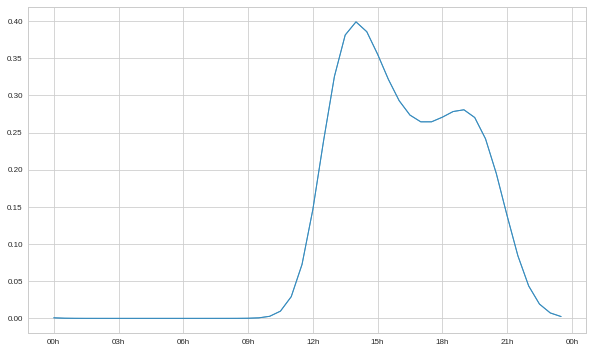

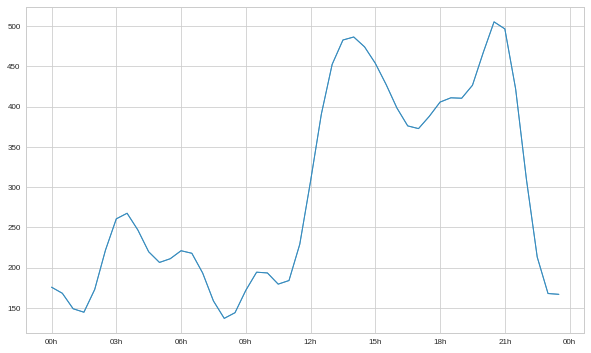

In [30]:
#  plot the sample for checking
plt.figure(figsize=(10,6))
Z_time=np.array([np.datetime64('2019') + np.timedelta64(int(k*60*60), 's') for k in Z])

for i in range(0,lengths.shape[0]):
    plt.plot(Z_time[np.argsort(Z_time)],lengths[i,np.argsort(Z_time)],c='C1',alpha=0.902,linewidth=1.0)

ax = plt.gca()
ax.xaxis_date()
ax.xaxis.set_major_formatter(myFmt)
plt.figure(figsize=(10,6))

for i in range(0,amps.shape[0]):
    plt.plot(Z_time[np.argsort(Z_time)],amps[i,np.argsort(Z_time)],c='C1', alpha=0.902,linewidth=1.0)
ax = plt.gca()
ax.xaxis_date()
ax.xaxis.set_major_formatter(myFmt)

In [ ]:

def build_trainable_location_scale_distribution(initial_loc, initial_scale):
    
    with tf.name_scope('build_trainable_location_scale_distribution'):
        dtype = tf.float32
        initial_loc = initial_loc * tf.ones(tf.shape(initial_scale), dtype=dtype)
        
        initial_scale = initial_scale * tf.ones_like(initial_loc)

        loc = tf.Variable(initial_value=initial_loc, name='loc')
      
        
        scale=tfp.util.DeferredTensor(tf.nn.softplus,tf.Variable(initial_scale, name='scale'))

        posterior_dist = tfd.Normal(loc=loc, scale=scale)

        
        posterior_dist = tfd.Independent(posterior_dist)
        
    return posterior_dist


flat_component_dists = []


init_loc = mover_hmc.kernel_params[1]
init_scale = tf.random.uniform(shape=mover_hmc.kernel_params[1].shape, minval=-2, maxval=2, dtype=tf.dtypes.float32)

    
flat_component_dists.append(build_trainable_location_scale_distribution(init_loc,init_scale))


init_loc = mover_hmc.kernel_params[3]
init_scale = tf.random.uniform(shape=mover_hmc.kernel_params[3].shape, minval=-2, maxval=2, dtype=tf.dtypes.float32)

    
flat_component_dists.append(build_trainable_location_scale_distribution(init_loc,init_scale))

surrogate_posterior = tfd.JointDistributionSequential(flat_component_dists)



def target_log_prob_fn(*inputs):
    params = []
    #print(inputs)
    #print('----------')
    params.append(mover_hmc.kernel_params[0])
    params.append(tf.squeeze(inputs[0]))
    params.append(mover_hmc.kernel_params[2])
    params.append(tf.squeeze(inputs[1]))
    #params = [tf.squeeze(a) for a in inputs]
    loss = mover_hmc.log_posterior(*params)
    
    #print(loss)
    return loss




start = time.time()
losses = tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn, surrogate_posterior,
    optimizer=tf.optimizers.Adam(
        learning_rate=0.1,
        # Decay second-moment estimates to aid optimizing scale parameters.
        beta_2=0.9),
    num_steps=1500)
end = time.time()
print(end - start)





In [ ]:
sp = surrogate_posterior.sample(100)
sp_np = [s.numpy() for s in sp]
approximate_posterior_stddevs = [np.std(x) for x in sp]
s1 = np.std(sp_np[0],axis=0)
m1 = np.mean(sp_np[0],axis=0)

s2 = np.std(sp_np[1],axis=0)
m2 = np.mean(sp_np[1],axis=0)

#plt.plot(Z[np.argsort(Z,axis=0)][:,0],m1[np.argsort(Z,axis=0)][:,0])
plt.plot(Z[np.argsort(Z,axis=0)][:,0],surrogate_posterior.mean()[0].numpy()[np.argsort(Z,axis=0)][:,0])
plt.plot(Z[np.argsort(Z,axis=0)][:,0],mover_hmc.kernel_params[1].numpy()[np.argsort(Z,axis=0)][:,0])

plt.show()

plt.plot(Z[np.argsort(Z,axis=0)][:,0],s1[np.argsort(Z,axis=0)][:,0])
plt.plot(Z[np.argsort(Z,axis=0)][:,0],s2[np.argsort(Z,axis=0)][:,0])

#opt_amp_mean

In [ ]:
X,T,ID = setup_data(skip_i=1)

# opt_ls_v = mover_hmc.kernel_params[1].numpy()
# opt_amp_v = mover_hmc.kernel_params[3].numpy()

mover_hmc = []

mover_hmc = moveNS(T,X,Z, ID, BATCH_SIZE=2800, data_steps = [1], velocity=True, std_obs_noise=0, mean_obs_noise=opt_obs_noise,
                        akernel=amp_periodic_kernel, 
                        aparams_init=aparams_init, 
                        apriors=apriors, 
                        atransforms=transforms,
                        lkernel=ls_periodic_kernel, 
                        lparams_init=lparams_init, 
                        lpriors=lpriors, 
                        ltransforms=transforms)


mover_hmc.kernel_params[1].assign(opt_ls_v)
mover_hmc.kernel_params[3].assign(opt_amp_v)

## Run the sampler

In [ ]:

start = time.time()

num_samples=1000
burn_in=500
num_runs=4
rescale = 24

for i in range(num_runs):
    
    steps = []
    for j, param in enumerate(mover_hmc.kernel_params):
        if j==1:
            steps.append(s1)
        elif j==3:
            steps.append(s2)
        else:
            steps.append(0)
    kr = mover_hmc.hmc_sample(num_samples=num_samples, skip=0, burn_in=burn_in, num_leapfrog_steps=8, init_step=steps)
   
    # save the results
    final_hmc_np = [j.numpy() for j in  mover_hmc.samples_]
    with open('data/hmc_samples_p_' + str(i) + '.npy', 'wb') as fp:
        pickle.dump(final_hmc_np, fp)
        
    lengths = mover_hmc.get_lengthscale_samples()
    amps = mover_hmc.get_amplitude_samples()
    np.save('data/len_sheep_p_' + str(i) + '.npy',lengths)
    np.save('data/amp_sheep_p_' + str(i) + '.npy',amps)
    
    Z_pred = np.arange(0,1.0*rescale,rescale*0.001).astype(np.float64)[:,None]
    lengths = mover_hmc.get_lengthscale_samples(X=Z_pred)
    amps = mover_hmc.get_amplitude_samples(X=Z_pred)

    np.save('data/full_len_sheep_p_' + str(i) + '.npy',lengths)
    np.save('data/full_amp_sheep_p_' + str(i) + '.npy',amps)
    np.save('data/Z_pred_p_' + str(i) + '.npy',Z_pred)

    
    end = time.time()
    print(i,end - start)

In [ ]:

print(i,0.8*1500*(end - start)/60/60/400)
np.sum(kr.inner_results.is_accepted.numpy()/num_samples)


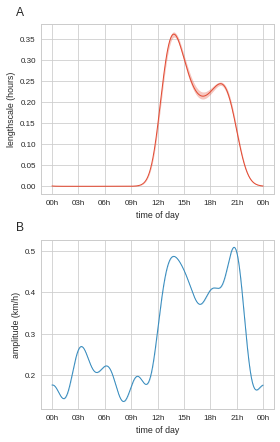

In [21]:



#amps = np.load('data/amps.npy')


gridsize = (2, 1)
fig = plt.figure(figsize=(4, 6))
ax1 = plt.subplot2grid(gridsize, (0, 0))
ax2 = plt.subplot2grid(gridsize, (1, 0))



Z_time=np.array([np.datetime64('2019') - np.timedelta64(0, 'h') + np.timedelta64(int(k*60*60*24/rescale), 's') for k in Z_pred])



ax1.plot(Z_time, np.mean(lengths, 0),c='C0', lw=1)

ax1.fill_between(Z_time[:],
                 np.percentile(lengths, 2.5, axis=0)[:,0],
                 np.percentile(lengths, 97.5, axis=0)[:,0],
                 color='C0', alpha = 0.3)

# #plt.xlim(0,1)
#ax1.set_ylim(0,0.2)

# #plt.xlim(0,1)
# ax = plt.gca()
ax1.xaxis_date()
#ax1.yaxis.set_major_locator(ticker.MultipleLocator(0.05))


ax1.xaxis.set_major_formatter(myFmt)
# #plt.gcf autofmt_xdate()
ax1.set_xlabel('time of day')
ax1.set_ylabel('lengthscale (hours)')
#ax1.set_yticklabels([])





ax1.xaxis.set_major_formatter(myFmt)


ax2.plot(Z_time, np.mean(amps/1000, 0),c='C1', lw=1) # x3.6 to convert m/s to km/h

ax2.fill_between(Z_time[:],
                 np.percentile(amps/1000, 2.5, axis=0)[:,0],
                 np.percentile(amps/1000, 97.5, axis=0)[:,0],
                 color='C1', alpha = 0.3)

# #plt.xlim(0,1)
#ax2.set_ylim(0,0.2)

# #plt.xlim(0,1)
# ax = plt.gca()
ax2.xaxis_date()
ax2.yaxis.set_major_locator(ticker.MultipleLocator(0.1))


ax2.xaxis.set_major_formatter(myFmt)
# #plt.gcf autofmt_xdate()
ax2.set_xlabel('time of day')
ax2.set_ylabel('amplitude (km/h)')
#ax2.set_yticklabels([])







plt.tight_layout(h_pad=2,w_pad=3)



xp = ax1.get_position().x0
yp = ax1.get_position().y1    
fig.text(xp - .09, yp+ .02, 'A', size=12)

xp = ax2.get_position().x0
yp = ax2.get_position().y1    
fig.text(xp - .09, yp+ .02, 'B', size=12)

plt.savefig('figures/sheep_combined.png', dpi=300, bbox_inches = "tight")
#np.save('hmc_samples' + str(i) + '.npy', final_hmc_np)

In [ ]:
plt.plot(kr.new_step_size[1][-1,:10].numpy())
plt.plot(0.3*opt_step[2][0:10])

In [ ]:
plt.plot(m1)
plt.plot(opt_ls_v)
plt.show()
plt.plot(m2)
plt.plot(mover_hmc.kernel_params[3].numpy())
plt.show()


In [ ]:
plt.plot(opt_step[2])
plt.plot(s1)
#plt.show()

plt.plot(opt_step[6])
plt.plot(s2,label='vi')
plt.legend()
plt.show()

In [ ]:

start = time.time()

num_samples=500#00
burn_in=500#00
num_runs=1

for i in range(num_runs):
    steps = []
    for j, param in enumerate(mover_hmc.kernel_params):
        if j==1:
            steps.append(1e-3*((opt_step[0])))#*(opt_step[0]))#/np.max(opt_step[0]))# (np.abs(gradients[2].numpy())**-1)/np.max(np.abs(gradients[2].numpy())**-1)) # np.full(shape=i.shape,fill_value=2e-3))#2e-3))
        elif j==3:
            steps.append(1e-3*((opt_step[1])))#/np.max(opt_step[1]))#(np.abs(gradients[5].numpy())**-1)/np.max(np.abs(gradients[5].numpy())**-1)) # np.full(shape=i.shape,fill_value=2e-3))#2e-3))
        else:
            steps.append(0)#1e-4)
    kr = mover_hmc.hmc_sample(num_samples=num_samples, skip=0, burn_in=burn_in, num_leapfrog_steps=5, init_step=steps)#1e-4)
   
    # save the results
    final_hmc_np = [j.numpy() for j in  mover_hmc.samples_]
    with open('hmc_samples_p_' + str(i) + '.npy', 'wb') as fp:
        pickle.dump(final_hmc_np, fp)
        
    lengths = mover_hmc.get_lengthscale_samples()
    amps = mover_hmc.get_amplitude_samples()
    np.save('data/len_sheep_p_' + str(i) + '.npy',lengths)
    np.save('data/amp_sheep_p_' + str(i) + '.npy',amps)
    
    end = time.time()
    print(i,end - start)

In [ ]:
print(i,(end - start)/60)
np.sum(kr.inner_results.is_accepted.numpy()/num_samples)


In [ ]:
# plt.hist(lengths,bins=100)
# plt.show()


import matplotlib.dates as mdates
myFmt = mdates.DateFormatter('%H:%M')

plt.figure(figsize=(10,6))

Z2 = Z % 24
Z_time=np.array([np.datetime64('2019') + np.timedelta64(int(k*60*60*24/rescale), 's') for k in Z_pred])


#for i in np.unique(ID):
    
    #plt.plot(T[i==ID],X[i==ID,0],label='x-position')
    #plt.plot(X[i==ID,0],X[i==ID,1],label='y-position',lw=1)
#plt.legend(loc='best')

#plt.axis('equal')

#plt.xlim(0,1)
#plt.ylim(0,4)
#plt.xlabel('time (days)')
#plt.show()

for i in range(0,lengths.shape[0]):
    #if i>50:
        #plt.plot(means[i,:,0],means[i,:,1],c='C1', alpha=0.1,linewidth=1.0)
    plt.plot(Z_time,lengths[i,:],'-',c='C0', alpha=0.5,linewidth=1.0)
ax = plt.gca()
ax.xaxis_date()
#plt.ylim(0,0.1)
ax.xaxis.set_major_formatter(myFmt)
plt.figure(figsize=(10,6))
#for i in np.unique(ID):
    
    #plt.plot(T[i==ID],X[i==ID,0],label='x-position')
    #plt.plot(X[i==ID,0],X[i==ID,1],label='y-position',lw=1)
#plt.legend(loc='best')

#plt.axis('equal')

#plt.xlim(0,1)

#plt.xlabel('time (days)')
#plt.show()
#plt.ylim(0,0.2)
for i in range(0,amps.shape[0]):
    #if i>50:
#     #plt.plot(means[i,:,0],means[i,:,1],c='C1', alpha=0.1,linewidth=1.0)
     plt.plot(Z_time,amps[i,:],'-',c='C1', alpha=0.5,linewidth=1.0)
ax = plt.gca()
ax.xaxis_date()
ax.xaxis.set_major_formatter(myFmt)

In [ ]:
with open ('opt_params.npy', 'rb') as fp:
    opt_params = pickle.load(fp)
 
    opt_obs_noise = opt_params[0]
    opt_ls_mean = opt_params[1]
    opt_ls_v = opt_params[2]
    opt_ls_amp = (opt_params[3]).numpy()
    opt_ls_ls = (opt_params[4]).numpy()
    opt_amp_mean = opt_params[5]
    opt_amp_v = opt_params[6]
    opt_amp_amp = (opt_params[7]).numpy()
    opt_amp_ls = (opt_params[8]).numpy()
    opt_step = opt_params[9]

In [ ]:
def sp_shift(x):
    # softplus transform with shift 
    return tf.nn.softplus(x)+1e-4

def periodic_kernel(x1,x2):
    # periodic kernel with single variable parameter. Other parameters are set 
    # to encode daily activity pattern (period=rescale).
    # 15 minute correlation time
    
    
    return tfk.ExpSinSquared(x1,x2,np.float64(rescale*1.0))


# transform for parameter to ensure positive
transforms=[sp_shift,sp_shift] 
mtransforms=[sp_shift,sp_shift] 

# prior distribution on parameters - changed to 20 
lpriors = [tfd.Normal(loc = np.float64(0.),scale=np.float64(10)),
           tfd.Normal(loc = np.float64(0.),scale=np.float64(10)),
           tfd.Normal(loc = np.float64(0.),scale=np.float64(10))]
           
apriors = [tfd.Normal(loc = np.float64(0),scale=np.float64(10.)),
           tfd.Normal(loc = np.float64(0),scale=np.float64(10.)),
           tfd.Normal(loc = np.float64(0.),scale=np.float64(10.))]



# random initial values of mean and kernel amplitude
#lparams_init = [p.sample().numpy()/10.0 for p in lpriors]
#aparams_init = [p.sample().numpy()/10.0 for p in apriors]

# random initial values of mean and kernel amplitude
lparams_init = [opt_ls_mean,opt_ls_amp,opt_ls_ls]
aparams_init = [opt_amp_mean,opt_amp_amp,opt_amp_ls]

#params_init = [1.0]# for p in lpriors]
#params_init = [stdX]#, 0.0]

# create the model 

mover_hmc = moveNS(T,X,Z, ID, BATCH_SIZE=2800, data_steps = [1], velocity=True, std_obs_noise=100, mean_obs_noise=10,
                        akernel=periodic_kernel, 
                        aparams_init=aparams_init, 
                        apriors=apriors, 
                        atransforms=transforms,
                        lkernel=periodic_kernel, 
                        lparams_init=lparams_init, 
                        lpriors=lpriors, 
                        ltransforms=transforms)#,
                        #mkernel=rbf_kernel, 
                        #mparams_init=mparams_init, 
                        #mpriors=mpriors, 
                        #mtransforms=mtransforms)
                
mover_hmc.kernel_params[0].assign(opt_obs_noise)                
mover_hmc.kernel_params[2].assign(opt_ls_v)
mover_hmc.kernel_params[6].assign(opt_amp_v)

In [ ]:
21*20/60

In [ ]:
surrogate_posterior = build_factored_surrogate_posterior(
    event_shape=[[], [], []],
    constraining_bijectors=[None, None,None])
# losses = tfp.vi.fit_surrogate_posterior(
#     mover.log_posterior, surrogate_posterior,
#     optimizer=tf.optimizers.Adam(
#         learning_rate=0.1,
#         # Decay second-moment estimates to aid optimizing scale parameters.
#         beta_2=0.9),
#     num_steps=1000)
# approximate_posterior_stddevs = [np.std(x) for x in surrogate_posterior.sample(50)]

In [ ]:
plt.plot(kr.new_step_size[2].numpy()[-1,:10])
plt.plot(opt_step[2][0:10],'.')


In [ ]:


plt.figure(figsize=(10,6))


for i in np.unique(ID):
    plt.plot(T[i==ID],X[i==ID,0],'.',label='x-position')
    #break
for i in range(0,means.shape[0]):

    
    plt.plot(Z,means[i,:,0],c='C1', alpha=0.9002,linewidth=1.0)


#plt.axis('equal')
plt.xlabel('time')
plt.ylabel('x-location')
plt.show()
plt.figure(figsize=(10,6))

for i in np.unique(ID):
    plt.plot(T[i==ID],X[i==ID,1],'.',label='x-position')
for i in range(0,means.shape[0]):

    plt.plot(Z,means[i,:,1],c='C1', alpha=0.9002,linewidth=1.0)
    

#plt.xlim(0,148)
#plt.axis('equal')
plt.xlabel('time')
plt.ylabel('y-location')
plt.show()


In [ ]:
Z

In [ ]:
# plot the trace
for i in range(len(mover.samples_)):
    plt.plot(mover.samples_[i].numpy())
    plt.show()


In [ ]:
mover.samples_[3].numpy()

In [ ]:
k = periodic_kernel(15.0)
tf.matmul(tf.linalg.cholesky(k.matrix(Z,Z)),tf.expand_dims(tf.cast(mover.kernel_params[2],tf.float64),-1))

In [ ]:
nl = []
shapes = []
for mk in mover.kernel_params:
    if len(mk.shape)==0:
        mk2 = tf.expand_dims(mk,-1)
        nl.append(mk2)
        shapes.append(mk2.get_shape().as_list()[0])
    else:
        nl.append(mk)
        shapes.append(mk.get_shape().as_list()[0])
#for mk in nl:
#    shapes.append(mk.shape)
params = tf.concat(nl,axis=0)
print(params.shape)


# The objective function and the gradient.

def objective_fn(position):
    position_as_list = [tf.squeeze(x) for x in tf.split(position,shapes)]
    


    #for i in range(len(position_as_list)):
    #    mover.kernel_params[i].assign(position_as_list[i].numpy())
    
    with tf.GradientTape() as t:
        t.watch(position_as_list)
        loss = -mover.log_posterior(*position_as_list)
    
    gradients = t.gradient(loss, position_as_list)
    
    #g_list = []
#
#    for g in gradients:
#        if len(g.shape)==0:
#            g2 = tf.expand_dims(g,-1)
#            g_list.append(g2)
##        
#        else:
#            g_list.append(g)
        
    return loss, gradients#tf.concat(g_list,axis=0)

start = params
optim_results = tfp.optimizer.lbfgs_minimize(objective_fn, 
                                                initial_position=start, 
                                                num_correction_pairs=10,
                                                tolerance=1e-1)

# Check that the search converged
print(optim_results.converged.numpy())
# True

# Check that the argmin is close to the actual value.
#print(np.allclose(optim_results.position.numpy(), minimum.numpy()))
# True






In [ ]:
optim_results.position.numpy()

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np

# A high-dimensional quadratic bowl.
ndims = 60
minimum = tf.ones([ndims], dtype='float64')
scales = tf.range(ndims, dtype='float64') + 1.0

# The objective function and the gradient.
@tf.function
def quadratic(x):
    value = tf.reduce_sum(scales * (x - minimum) ** 2)
    return value, tf.gradients(value, x)[0]

start = tf.range(ndims, 0, -1, dtype='float64')
optim_results = tfp.optimizer.lbfgs_minimize(
  quadratic, initial_position=start, num_correction_pairs=10,
  tolerance=1e-8)

# Check that the search converged
print(optim_results.converged.numpy())
# True

# Check that the argmin is close to the actual value.
print(np.allclose(optim_results.position.numpy(), minimum.numpy()))

quadratic(start)

## Diagnostics

In [ ]:
def sp(x):
    # softplus transform with shift 
    return tf.nn.softplus(x)+1e-4

def periodic_kernel(x1):
    # locally periodic kernel with single variable parameter. Other parameters are set 
    # to encode annual activity pattern (period=365), RBF kernel is set to allow for 
    # slow varying mean locations (2-year lengthscale).
    
    return tfk.ExpSinSquared(x1,np.float64(np.sqrt(np.pi/96.)),np.float64(1.0))


for run in range(5):

    # initial value of kernel amplitude
    lparams_init=[np.random.uniform(0,10.0)] 
    aparams_init=[np.random.uniform(0,10.0)] 

    # transform for parameter to ensure positive
    transforms=[sp] 

    # prior distribution on parameter 
    priors = [tfd.Uniform(low=np.float64(0.), high=np.float64(100.0))]

    # create the model 
    mover = moveNS(T,X,Z, ID, BATCH_SIZE=1000, velocity=True, 
                           akernel=periodic_kernel, 
                           aparams_init=lparams_init, 
                           apriors=priors, 
                           atransforms=transforms,
                           lkernel=periodic_kernel, 
                           lparams_init=aparams_init, 
                           lpriors=priors, 
                           ltransforms=transforms)



    start = time.time()

    # sample from the posterior
    mover.hmc_sample(num_samples=1000, skip=0, burn_in=500, init_step=1e-5)
    #mover.hmc_sample(num_samples=3, skip=0, burn_in=0)
    end = time.time()
    print(end - start)

    np.save('data/samples_sheep' + str(run) + '.npy',mover.samples_)

In [ ]:
save_sam[0][0]

In [ ]:
len(mover.kernel_params)

In [ ]:
mover.kernel_params[2]#.assign(0.4)

In [ ]:
for i in range(7):
    mover.kernel_params[i].assign(save_sam[i][-1])

In [ ]:
mover.kernel_params[1]

In [ ]:
mover.samples_[1]

In [ ]:
T

In [ ]:
1/(T[2]-T[1])

In [ ]:
X[2]-X[1]